In [197]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.ml.regression import GBTRegressor
import numpy as np
import time
import datetime
import os

spark = (
    SparkSession.builder.appName("ADS project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [162]:
sdf = spark.read.parquet('../data/curated/merchant_consumer_abs')
categories = sdf.select(col("merchant_name").alias("merchant_name_copy"), "category").distinct()
sdf = sdf.drop(*['postcode', 'products', 'take_rate', 'category', 'fraud_group',
                 'user_id', 'consumer', 'consumer_address', 'consumer_state', 'consumer_postcode', 'order_day',
                 '__index_level_0__'])
for i in sdf.columns[:8]:
    if i != "median_age":
        sdf = sdf.drop(i)
# for i in sdf.columns[:4]:
#     sdf = sdf.withColumn(f"log_{i}", when(log(col(i)) > 0, log(col(i))).otherwise(0)).drop(i).withColumnRenamed(f"log_{i}", i)
# sdf = sdf.select(*(sdf.columns[-4:]), *(sdf.columns[:-4]))
order = sdf.columns
sdf = sdf.withColumn("year", col("order_year").cast("int")).drop("order_year").withColumnRenamed("year", "order_year").select(*order)
sdf

median_age,merchant_name,revenue_level,order_datetime,tag,dollar_value,order_year,order_month,consumer_gender
33.00000004463053,Elit Sed Consequa...,a,2022-04-27,artist supply craft,375.16773164703153,2022,4,Female
33.00000004463053,Elit Sed Consequa...,a,2022-10-07,artist supply craft,617.8791313462011,2022,10,Male
33.00000004463053,Elit Sed Consequa...,a,2022-02-28,artist supply craft,766.5077067424303,2022,2,Female
33.00000004463053,Malesuada Vel Ltd,b,2021-07-24,books periodicals...,258.86595899218753,2021,7,Female
33.00000004463053,Varius Orci Insti...,a,2021-08-08,tent awning,4.159037931172075,2021,8,Female
33.00000004463053,Volutpat Nulla In...,a,2022-10-11,furniture home fu...,8.26105405068297,2022,10,Male
33.00000004463053,Mollis Integer Co...,b,2022-05-02,digital goods boo...,83.63154755239155,2022,5,Female
33.00000004463053,Elit Sed Consequa...,a,2021-04-08,artist supply craft,87.00495112586256,2021,4,Female
33.00000004463053,Eros Limited,c,2021-12-18,digital goods boo...,8.26187754879106,2021,12,Female
33.00000004463053,Hendrerit A Corpo...,a,2022-07-14,watch clock jewel...,100.80643267043831,2022,7,Male


In [163]:
to_do = {'2022': [11, 12],
         '2023': range(1,13)}
merchs = sdf.select("merchant_name", "revenue_level", "tag").distinct()
cols = ["median_age", "order_datetime_str", "dollar_value", "order_year", "order_month", "consumer_gender"]
vals = [(0, f"{year}-{str(month).rjust(2, '0')}-01", 0, int(year), month, "Female") for year in to_do for month in to_do[year]]
months = spark.createDataFrame(vals, cols)
cols.remove("order_datetime_str")
months = months.select(*cols, to_date(col("order_datetime_str"), "yyyy-MM-dd").alias("order_datetime"))
predict = merchs.join(months).select(sdf.columns)
sdf = sdf.union(predict)
sdf

median_age,merchant_name,revenue_level,order_datetime,tag,dollar_value,order_year,order_month,consumer_gender
33.00000004463053,Elit Sed Consequa...,a,2022-04-27,artist supply craft,375.16773164703153,2022,4,Female
33.00000004463053,Elit Sed Consequa...,a,2022-10-07,artist supply craft,617.8791313462011,2022,10,Male
33.00000004463053,Elit Sed Consequa...,a,2022-02-28,artist supply craft,766.5077067424303,2022,2,Female
33.00000004463053,Malesuada Vel Ltd,b,2021-07-24,books periodicals...,258.86595899218753,2021,7,Female
33.00000004463053,Varius Orci Insti...,a,2021-08-08,tent awning,4.159037931172075,2021,8,Female
33.00000004463053,Volutpat Nulla In...,a,2022-10-11,furniture home fu...,8.26105405068297,2022,10,Male
33.00000004463053,Mollis Integer Co...,b,2022-05-02,digital goods boo...,83.63154755239155,2022,5,Female
33.00000004463053,Elit Sed Consequa...,a,2021-04-08,artist supply craft,87.00495112586256,2021,4,Female
33.00000004463053,Eros Limited,c,2021-12-18,digital goods boo...,8.26187754879106,2021,12,Female
33.00000004463053,Hendrerit A Corpo...,a,2022-07-14,watch clock jewel...,100.80643267043831,2022,7,Male


In [110]:
genders = sdf.select("consumer_gender").distinct().rdd.flatMap(lambda x: x).collect()
exprs = [when(col("consumer_gender") == category, 1).otherwise(0).alias(category)
         for category in genders]
sdf = sdf.select(*(sdf.columns), *exprs).drop("consumer_gender")

In [111]:
train = sdf.where((col("order_datetime") <= "2022-10-31")).drop("order_datetime")
test = sdf.where((col("order_datetime") > "2022-10-31")).drop("order_datetime")

In [150]:
train_group = train
w = Window.partitionBy('merchant_name')
train_group = train_group.withColumn("avg(median_age)", avg("median_age").over(w)).drop("median_age")

In [151]:
agg_cols = train_group.columns
for i in ["dollar_value", "Female", "Male", "Undisclosed"]:
    agg_cols.remove(i)
train_group = train_group.groupBy(agg_cols).agg(sum("dollar_value"), sum("Female"), sum("Male"), sum("Undisclosed"))

In [189]:
fill = {'2021': range(3,13),
        '2022': range(1,11)}
merchs = train_group.select("merchant_name", "revenue_level", "tag", "avg(median_age)").distinct()
cols = ["order_year", "order_month", "sum(dollar_value)", "sum(Female)", "sum(Male)", "sum(Undisclosed)"]
vals = [(int(year), month, 0, 0, 0, 0) for year in fill for month in fill[year]]
months = spark.createDataFrame(vals, cols)
months = merchs.join(months).select(train_group.columns)
train_agg = train_group.union(months)

In [190]:
group_cols = [i for i in train_agg.columns if "sum" not in i]
agg_cols = [i for i in train_agg.columns if "sum" in i]
train_agg = train_agg.groupBy(group_cols).max()
train_agg = train_agg.drop(*["max(order_month)", "max(avg(median_age))", "max(order_year)"])
for i in agg_cols:
    train_agg = train_agg.withColumnRenamed(f"max({i})", i)
train_agg = train_agg.withColumnRenamed("sum(dollar_value)", "dollar_value")

w = Window.partitionBy('merchant_name')
for i in genders:
    train_agg = train_agg.withColumn(f"avg(sum({i}))", avg(f"sum({i})").over(w)).drop(f"sum({i})")

In [191]:
test_agg = test.select(test.columns[1:7])
merch_agg = train_agg.select(col("merchant_name").alias("merchant_name_copy"), *(train_agg.columns[5:])).drop("dollar_value").distinct()
test_agg = test_agg.join(merch_agg, test_agg.merchant_name == merch_agg.merchant_name_copy, "left").drop("merchant_name_copy")
test_agg = test_agg.select(*(train_agg.columns))

In [166]:
merch_meta = train_agg.select('merchant_name', 'revenue_level', 'avg(median_age)',
                              'avg(sum(Undisclosed))', 'avg(sum(Female))', 'avg(sum(Male))').distinct()
merch_meta = merch_meta.join(categories, merch_meta.merchant_name == categories.merchant_name_copy).drop("merchant_name_copy")
merch_meta.write.parquet('../data/meta/merchant_metadata.parquet')

22/10/09 00:16:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:16:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:16:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:16:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


In [192]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, Interaction

interact = ["tag", "revenue_level", "order_month"]
for i in interact:
    stringIndexer = StringIndexer(inputCol=i, outputCol=f"{i}_num")
    train_agg = stringIndexer.fit(train_agg).transform(train_agg).drop(i)
    test_agg = stringIndexer.fit(test_agg).transform(test_agg)
    encoder = OneHotEncoder(inputCol=f"{i}_num", outputCol=i+"_vec")
    train_agg = encoder.fit(train_agg).transform(train_agg).drop(f"{i}_num")
    test_agg = encoder.fit(test_agg).transform(test_agg).drop(f"{i}_num")
interaction = Interaction(inputCols=[f"{i}_vec" for i in interact], outputCol="interact")
train_agg = interaction.transform(train_agg)
test_agg = interaction.transform(test_agg)

22/10/09 00:40:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:40:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:40:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:40:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 00:41:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:41:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:41:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:41:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 00:42:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:42:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:42:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:42:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


In [193]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

feats = train_agg.columns
feats.remove('merchant_name')
feats.remove('dollar_value')
assembler = VectorAssembler(inputCols=feats, outputCol="features")
train_vec = assembler.transform(train_agg)
test_vec = assembler.transform(test_agg)

In [194]:
train_lm = train_vec.select("features", col("dollar_value").alias("label"))
test_lm = test_vec.select('merchant_name', 'order_year', 'order_month', "features")

In [195]:
from pyspark.ml.regression import GBTRegressor

GBT = GBTRegressor(featuresCol="features")
gbt = GBT.fit(train_lm)
gbt_predict = gbt.transform(test_lm)
# print("Root Mean Squared Error (RMSE) = %g" % rmse_evaluator.evaluate(gbt_predict))
# print("R Squared (R2) = %g" % r2_evaluator.evaluate(gbt_predict))

In [196]:
gbt_predict

22/10/09 00:44:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:44:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:44:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:44:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/09 00:44:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:44:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


merchant_name,order_year,order_month,features,prediction
Varius Orci Insti...,2022,11,"(1100,[0,1,2,3,4,...",339428.310681479
Semper Incorporated,2022,11,"(1100,[0,1,2,3,4,...",4935.524590550981
Hendrerit Consect...,2022,11,"(1100,[0,1,2,3,4,...",19781.567670102813
Erat Semper Ltd,2022,11,"(1100,[0,1,2,3,4,...",33246.109645328266
Vel Turpis Company,2022,11,"(1100,[0,1,2,3,4,...",6139.381734603869
Curabitur Vel LLC,2022,11,"(1100,[0,1,2,3,4,...",1054.256194760029
Vulputate Velit E...,2022,11,"(1100,[0,1,2,3,4,...",1682.3959347538864
Porttitor Eros In...,2022,11,"(1100,[0,1,2,3,4,...",11023.37784341897
Dictum Mi Incorpo...,2022,11,"(1100,[0,1,2,3,4,...",22878.786272571964
Pede Praesent Ltd,2022,11,"(1100,[0,1,2,3,4,...",12461.083817826218


In [198]:
os.makedirs("../data/meta/", exist_ok=True)
gbt_predict.select("merchant_name", "order_year", "order_month", "prediction").write.parquet("../data/meta/predictions.parquet")

22/10/09 00:50:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:50:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:50:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/09 00:50:40 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

tmp = train_agg.toPandas()

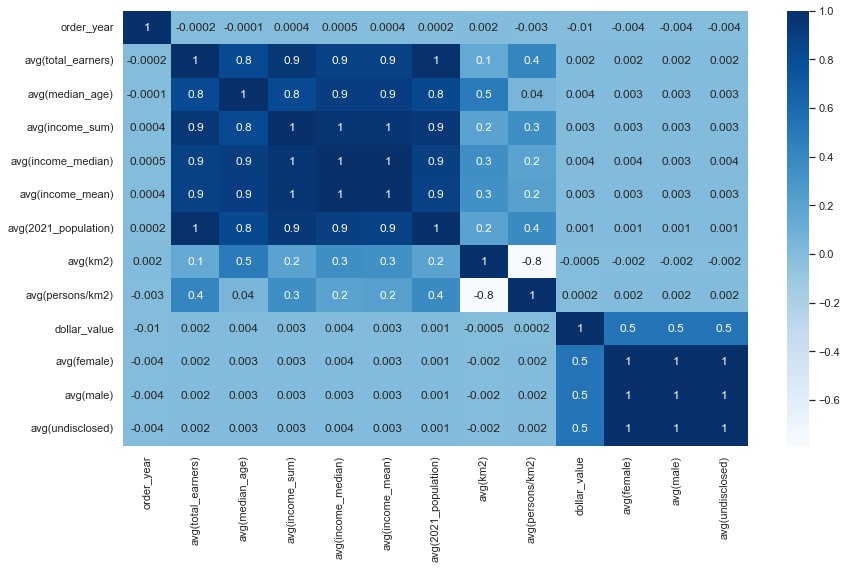

In [ ]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = tmp.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

In [ ]:
corr.dollar_value

order_year             -0.009990
avg(total_earners)      0.001780
avg(median_age)         0.004022
avg(income_sum)         0.002916
avg(income_median)      0.003509
avg(income_mean)        0.003313
avg(2021_population)    0.001089
avg(km2)               -0.000479
avg(persons/km2)        0.000221
dollar_value            1.000000
avg(female)             0.529317
avg(male)               0.529381
avg(undisclosed)        0.530022
Name: dollar_value, dtype: float64